#### use rCBF, rCBV here due to unclear correction factors

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
import scipy.ndimage
import matplotlib.cm
import imageio
import time

In [100]:
sys.path.append('../../Preprocess/')
import CalcParaMaps
import BiasCorrection

In [101]:
frames = {}
cbfs = {}
cbvs = {}
mtts = {}
ttps = {}
frames_ot = {}
imgNorm = 0.15
testOffset = 17
iImg = 2
iSlice = 1

In [102]:
# read references
refDir = '/home/dwu/trainData/Noise2Noise/train/ctp/real/data/'
img = np.load(os.path.join(refDir, 'imgs4d.npy'), allow_pickle=True)[testOffset + iImg][[iSlice], ...] / 1000 / imgNorm
mask = np.load(os.path.join(refDir, 'mask.npy'), allow_pickle=True)[testOffset + iImg][[iSlice], ...][...,0]
aif = np.load(os.path.join(refDir, 'aif.npy'), allow_pickle=True)[testOffset + iImg] / 1000 / imgNorm
vof = np.load(os.path.join(refDir, 'vof.npy'), allow_pickle=True)[testOffset + iImg] / 1000 / imgNorm
# the additional factor is to make normal white matter's CBF to 22, CBV to 10
cbfFac = np.load(os.path.join(refDir, 'cbfFac.npy'), allow_pickle=True)[testOffset + iImg] / 5.5
cbvFac = np.load(os.path.join(refDir, 'cbvFac.npy'), allow_pickle=True)[testOffset + iImg] / 10
ot = np.load(os.path.join(refDir, 'ot.npy'), allow_pickle=True)[testOffset + iImg][iSlice, 32:-32, 32:-32, 0]

In [103]:
# vessel mask from img
maskVessels = np.where(np.max(img, -1) > 0.1 / imgNorm, 1, 0)
maskVessels *= mask
for i in range(maskVessels.shape[0]):
    maskVessels[i,...] = scipy.ndimage.morphology.binary_dilation(maskVessels[i,...])
mask *= (1-maskVessels)

img *= mask[...,np.newaxis]
ctp = img - (img[...,[0]] + img[...,[1]]) / 2

In [104]:
def GetResults(ctp, aif, vof, mask, cbfFac, cbvFac, iFrame = 20):
    cbf, cbv, mtt = CalcParaMaps.CalcParaMaps(ctp, mask[...,np.newaxis], aif = np.copy(aif), kappa = 1, vof = np.copy(vof), directCBV = False)
    cbf *= cbfFac
    cbv *= cbvFac
    mtt = mtt / cbfFac * cbvFac
    ttp = np.argmax(ctp, -1)
    
    mask = mask[0,32:-32,32:-32]
    
    return ctp[0, 32:-32, 32:-32, iFrame] * mask, cbf[0, 32:-32, 32:-32] * mask, cbv[0, 32:-32, 32:-32] * mask, mtt[0, 32:-32, 32:-32] * mask, ttp[0, 32:-32, 32:-32] * mask

In [105]:
# display color map
# cmap = matplotlib.cm.nipy_spectral
cmap = matplotlib.cm.jet(np.arange(256))
cmap[0, :-1] = 0
# cmapDict = cmap._segmentdata
# cmapDict['green'][-1] = (1.0, 0.0, 0.0)
# cmapDict['blue'][-1] = (1.0, 0.0, 0.0)
newCmap = matplotlib.colors.ListedColormap(cmap, 'perfusion', N=256)

In [106]:
# blend ot with frame image
def Blend_frame_with_ot(frame, ot, vmin=0, vmax=0.1, alpha = 0.3, channel = 1):
    img = (frame - vmin) / (vmax - vmin)
    img[img < 0] = 0
    img[img > 1] = 1
    img = np.tile(img[...,np.newaxis], (1,1,3))
    mask = np.zeros_like(img)
    
    ot_edge = ot - scipy.ndimage.morphology.binary_erosion(ot, iterations = 2)
    mask[..., channel] = ot * alpha + ot_edge * (1-alpha) / 2
    img = img * (1 - mask) + mask
    
    return img

0.13573455810546875


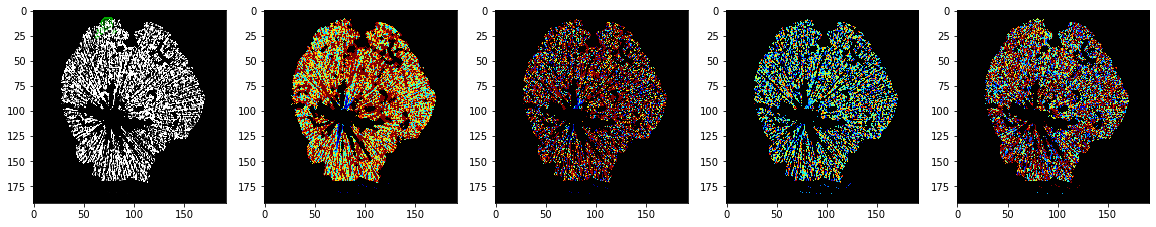

In [107]:
# paramaps for raw
raw = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_0.npy', allow_pickle=True)[iImg][[iSlice], ...]
start = time.time()
frame, cbf, cbv, mtt, ttp = GetResults(raw, aif, vof, mask, cbfFac, cbvFac, iFrame=20)
print (time.time() - start)

name = 'raw'
frames[name] = frame
frames_ot[name] = Blend_frame_with_ot(frame, ot)
cbfs[name] = cbf
cbvs[name] = cbv
mtts[name] = mtt
ttps[name] = ttp

plt.figure(figsize = [20,4])
# plt.subplot(151); plt.imshow(frame, 'gray', vmin=0, vmax=0.1)
plt.subplot(151); plt.imshow(frames_ot[name])
plt.subplot(152); plt.imshow(cbf, newCmap, vmin=0, vmax=75)
plt.subplot(153); plt.imshow(cbv, newCmap, vmin=0, vmax=6)
plt.subplot(154); plt.imshow(mtt, newCmap, vmin=0, vmax=10)
plt.subplot(155); plt.imshow(ttp, newCmap, vmin=15, vmax=25)

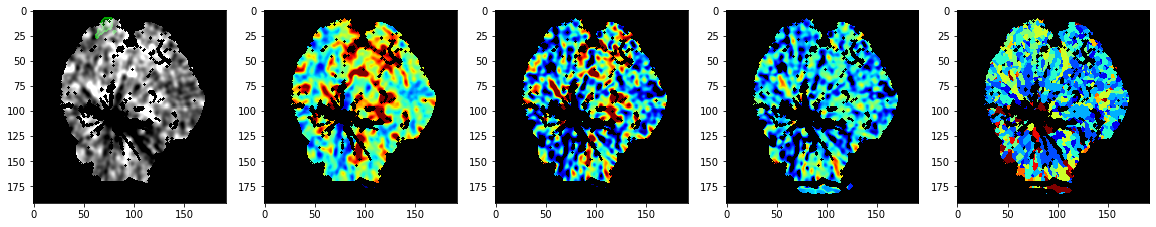

In [108]:
# paramaps for gaussian
gauss = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_2.npy', allow_pickle=True)[iImg][[iSlice], ...]
frame, cbf, cbv, mtt, ttp = GetResults(gauss, aif, vof, mask, cbfFac, cbvFac)

name = 'gauss'
frames[name] = frame
frames_ot[name] = Blend_frame_with_ot(frame, ot)
cbfs[name] = cbf
cbvs[name] = cbv
mtts[name] = mtt
ttps[name] = ttp

plt.figure(figsize = [20,4])
# plt.subplot(151); plt.imshow(frame, 'gray', vmin=0, vmax=0.1)
plt.subplot(151); plt.imshow(frames_ot[name])
plt.subplot(152); plt.imshow(cbf, newCmap, vmin=0, vmax=75)
plt.subplot(153); plt.imshow(cbv, newCmap, vmin=0, vmax=6)
plt.subplot(154); plt.imshow(mtt, newCmap, vmin=0, vmax=10)
plt.subplot(155); plt.imshow(ttp, newCmap, vmin=15, vmax=25)

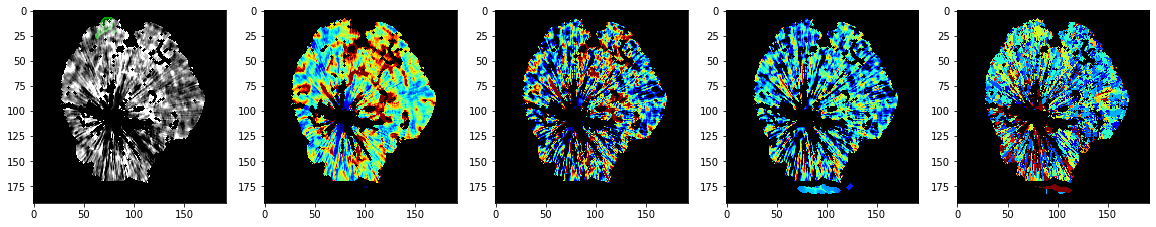

In [109]:
# paramaps for TIPS
tips = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.075_2.npy', allow_pickle=True)[iImg][[iSlice], ...]
frame, cbf, cbv, mtt, ttp = GetResults(tips, aif, vof, mask, cbfFac, cbvFac)

name = 'tips'
frames[name] = frame
frames_ot[name] = Blend_frame_with_ot(frame, ot)
cbfs[name] = cbf
cbvs[name] = cbv
mtts[name] = mtt
ttps[name] = ttp

plt.figure(figsize = [20,4])
# plt.subplot(151); plt.imshow(frame, 'gray', vmin=0, vmax=0.1)
plt.subplot(151); plt.imshow(frames_ot[name])
plt.subplot(152); plt.imshow(cbf, newCmap, vmin=0, vmax=75)
plt.subplot(153); plt.imshow(cbv, newCmap, vmin=0, vmax=6)
plt.subplot(154); plt.imshow(mtt, newCmap, vmin=0, vmax=10)
plt.subplot(155); plt.imshow(ttp, newCmap, vmin=15, vmax=25)

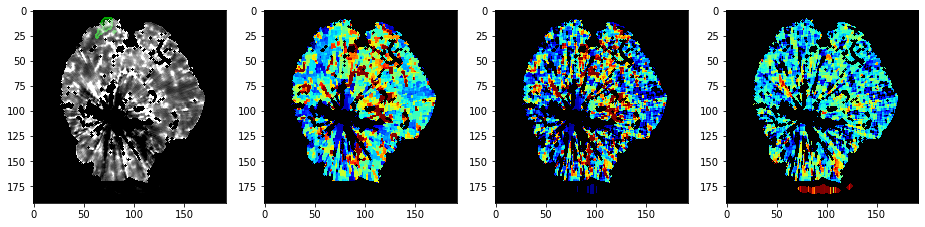

In [111]:
# paramaps for TV
# this is a little different
with np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_1e-3_1e-4.npz', allow_pickle=True) as f:
    localMask = mask[0, 32:-32, 32:-32]
    cbf = f['cbf'][iImg][iSlice, 32:-32, 32:-32] * localMask / 5.5
    cbv = f['cbv'][iImg][iSlice, 32:-32, 32:-32] * localMask * cbvFac
    mtt = f['mtt'][iImg][iSlice, 32:-32, 32:-32] * localMask * 5.5 * cbvFac
#     ttp = f['ttp'][iImg][iSlice, 32:-32, 32:-32] * localMask

name = 'tv'
frames[name] = frame
frames_ot[name] = Blend_frame_with_ot(frame, ot)
cbfs[name] = cbf
cbvs[name] = cbv
mtts[name] = mtt
ttps[name] = ttp

plt.figure(figsize = [20,4])
# plt.subplot(151); plt.imshow(frame, 'gray', vmin=0, vmax=0.1)
plt.subplot(151); plt.imshow(frames_ot[name])
plt.subplot(152); plt.imshow(cbf, newCmap, vmin=0, vmax=75)
plt.subplot(153); plt.imshow(cbv, newCmap, vmin=0, vmax=6)
plt.subplot(154); plt.imshow(mtt, newCmap, vmin=0, vmax=10)
# plt.subplot(155); plt.imshow(ttp, newCmap, vmin=15, vmax=25)

0.16097164154052734


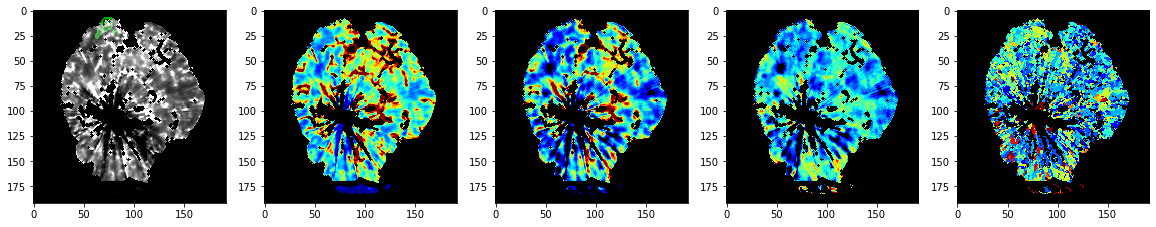

In [110]:
# paramaps for Noise2Noise
n2n = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_37.5/tmp/iodines.npy', allow_pickle=True)[iImg + testOffset][[iSlice], ...] * 0.025 / imgNorm
# n2n = BiasCorrection.BiasCorrection(n2n, ctp, mask[...,np.newaxis])
start = time.time()
frame, cbf, cbv, mtt, ttp = GetResults(n2n, aif, vof, mask, cbfFac, cbvFac)
print (time.time() - start)

name = 'n2n'
frames[name] = frame
frames_ot[name] = Blend_frame_with_ot(frame, ot)
cbfs[name] = cbf
cbvs[name] = cbv
mtts[name] = mtt
ttps[name] = ttp

plt.figure(figsize = [20,4])
# plt.subplot(151); plt.imshow(frame, 'gray', vmin=0, vmax=0.1)
plt.subplot(151); plt.imshow(frames_ot[name])
plt.subplot(152); plt.imshow(cbf, newCmap, vmin=0, vmax=75)
plt.subplot(153); plt.imshow(cbv, newCmap, vmin=0, vmax=6)
plt.subplot(154); plt.imshow(mtt, newCmap, vmin=0, vmax=10)
plt.subplot(155); plt.imshow(ttp, newCmap, vmin=15, vmax=25)

In [94]:
n2n.shape

(1, 256, 256, 44)

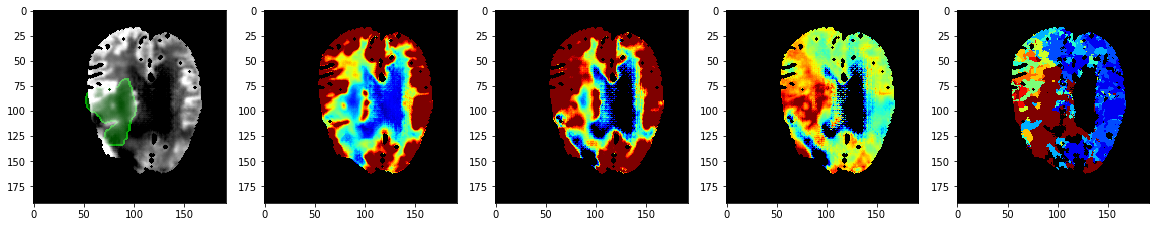

In [95]:
# paramaps for supervised
sup = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_12.5.npy', allow_pickle=True)[iImg][[iSlice], ...] * 0.025 / imgNorm
# sup = BiasCorrection.BiasCorrection(sup, ctp, mask[...,np.newaxis])
frame, cbf, cbv, mtt, ttp = GetResults(sup, aif, vof, mask, cbfFac, cbvFac)

name = 'sup'
frames[name] = frame
frames_ot[name] = Blend_frame_with_ot(frame, ot)
cbfs[name] = cbf
cbvs[name] = cbv
mtts[name] = mtt
ttps[name] = ttp

plt.figure(figsize = [20,4])
# plt.subplot(151); plt.imshow(frame, 'gray', vmin=0, vmax=0.1)
plt.subplot(151); plt.imshow(frames_ot[name])
plt.subplot(152); plt.imshow(cbf, newCmap, vmin=0, vmax=75)
plt.subplot(153); plt.imshow(cbv, newCmap, vmin=0, vmax=6)
plt.subplot(154); plt.imshow(mtt, newCmap, vmin=0, vmax=10)
plt.subplot(155); plt.imshow(ttp, newCmap, vmin=15, vmax=25)

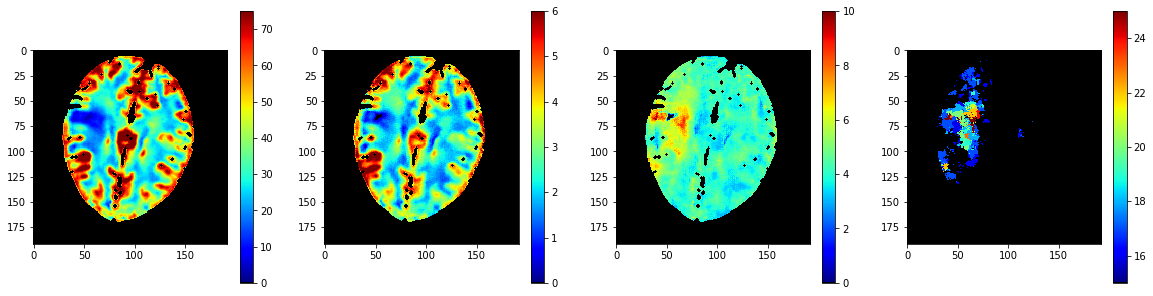

In [14]:
# plot the colorbars
plt.figure(figsize = [20,5])
plt.subplot(141); plt.imshow(cbf, newCmap, vmin=0, vmax=75); plt.colorbar()
plt.subplot(142); plt.imshow(cbv, newCmap, vmin=0, vmax=6); plt.colorbar()
plt.subplot(143); plt.imshow(mtt, newCmap, vmin=0, vmax=10); plt.colorbar()
plt.subplot(144); plt.imshow(ttp, newCmap, vmin=15, vmax=25); plt.colorbar()

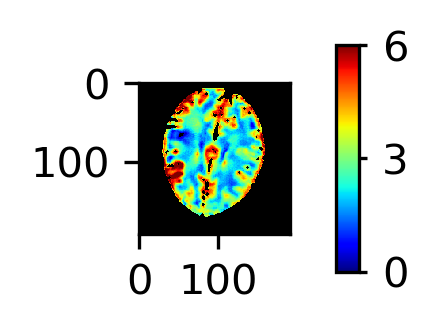

In [34]:
plt.figure(figsize = [1,1], dpi=300)
plt.imshow(mtt, newCmap, vmin=0, vmax=10)
cbar = plt.colorbar(pad = 0.2, aspect=10);
cbar.ax.tick_params(size = 2)
# cbar.set_ticks([0, 3, 6])

In [112]:
# save all the images
outDir = '/home/dwu/trainData/Noise2Noise/train/ctp/results/real/imgs_metal_2'
if not os.path.exists(outDir):
    os.makedirs(outDir)

In [97]:
def GetColorImg(img, cmap, vmin, vmax):
    img = (img - vmin) / (vmax - vmin) * 255
    img[img < 0] = 0
    img[img > 255] = 255
    img = cmap(img.astype(np.uint8)) * 255
    img = img.astype(np.uint8)
    
    return img

In [81]:
def SaveWithZoomIn(filename, img, rect, roiSize, dpi = 150):
    if rect is not None:
        subImg = img[rect[0]:rect[2], rect[1]:rect[3], :]
        subImg = scipy.ndimage.interpolation.zoom(subImg, (roiSize[0] / subImg.shape[0], roiSize[1] / subImg.shape[1], 1))

        img[-subImg.shape[0]:, -subImg.shape[1]:, :] = subImg
    
    ny = img.shape[0]
    nx = img.shape[1]
    
    plt.ioff()
    
    fig = plt.figure(figsize=[nx / dpi, ny / dpi], frameon=False, dpi = dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img)
    
    if rect is not None:
        ax.plot([rect[1], rect[1], rect[3], rect[3], rect[1]], 
                [rect[0], rect[2], rect[2], rect[0], rect[0]], 'w--', lineWidth = 1)
        ax.plot([nx - roiSize[0], nx - roiSize[0], nx-1, nx-1, nx - roiSize[0]], 
                [ny - roiSize[1], ny-1, ny-1, ny - roiSize[1], ny - roiSize[1]], 'w-', lineWidth=2)
    
    if filename is not None:
        plt.savefig(filename)
        plt.close(fig)
    
    plt.ion()
    
    return img

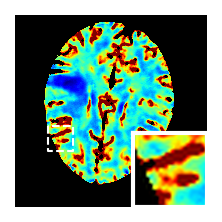

In [28]:
rx = 110
ry = 32
rect = [rx, ry, rx+25, ry+25]
roiSize = [75, 75]
_ = SaveWithZoomIn(None, GetColorImg(cbfs['n2n'], newCmap, 0, 75), rect, roiSize)

In [113]:
for k in frames:
    _ = SaveWithZoomIn(os.path.join(outDir, k+'_frame.png'), GetColorImg(frames[k], matplotlib.cm.gray, 0, 0.1), None, None)
#     _ = SaveWithZoomIn(os.path.join(outDir, k+'_cbf.png'), GetColorImg(cbfs[k], newCmap, 0, 75), rect, roiSize)
    _ = SaveWithZoomIn(os.path.join(outDir, k+'_cbf.png'), GetColorImg(cbfs[k], newCmap, 0, 75), None, None)
    _ = SaveWithZoomIn(os.path.join(outDir, k+'_cbv.png'), GetColorImg(cbvs[k], newCmap, 0, 6), None, None)
    _ = SaveWithZoomIn(os.path.join(outDir, k+'_mtt.png'), GetColorImg(mtts[k], newCmap, 0, 10), None, None)
#     _ = SaveImg(os.path.join(outDir, k+'_ttp.png'), ttps[k], newCmap, 15, 25)

In [64]:
# save frame with ot overlay
for k in frames:
    _ = SaveWithZoomIn(os.path.join(outDir, k+'_frame_with_ot.png'), frames_ot[k], None, None)